## Seguimiento espectroscópico de candidatos a binarias eclipsantes.

### Binarias eclipsantes.
La importancia del descubrimiento y estudio de binarias eclipsantes reside en que nos permite medir masas por medio de la tercera ley de Kepler. A su vez, conociendo la curva de luz y la velocidad radial, podemos determinar el radio de la estrella y así, conociendo también su luminosidad, saber la masa que le corresponde a un determinado tipo de estrella.

### Espectógrafo echelle.

### Wraight et al (2012)
#### Confirmados:
1. HD 75767
2. HD 213597

In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import ephem

# Lista de estrellas binarias candidatas
candidates = ['HD 23765', 'HD 287039', 'HD 89849',
              'BD-07 3648', 'HD 198044', 'HD 205403',
              'HD 222891']
ebs = {}

for name in candidates:
    coord = SkyCoord.from_name(name)
    star = ephem.FixedBody()
    star._ra = coord.ra.radian
    star._dec = coord.dec.radian
    star._epoch = 2000
    ebs[name] = star

In [2]:
oduc = ephem.Observer()
oduc.lon, oduc.lat = '289.4656', '-33.2692'
oduc.elevation = 1450
#oduc.pressure = 1014  # Quizás no.
oduc.date = ephem.Date('2016/11/14 00:00:00')

# Calculamos el Astronomical twilight (http://rhodesmill.org/pyephem/rise-set.html)
# Usaremos el civil, porque contamos con poco tiempo.
def cal_twilight(obs, date):
    obs.date = ephem.Date(date)
    obs.horizon = '-6'
    ret = obs.next_setting(ephem.Sun(), use_center=True)
    obs.horizon = '0'
    return ret

twilight = cal_twilight(oduc, oduc.date)

# Volvemos al valor de antes y situamos el observatorio en el twilight
oduc.horizon = '0'
oduc.date = twilight

def alt(star, obs):
    star.compute(obs)
    return star.alt > 0

for time in range(0, 4):
    oduc.date = twilight + ephem.hour * time
    ebs = {key: value for key, value in ebs.items() 
           if alt(value, oduc)}

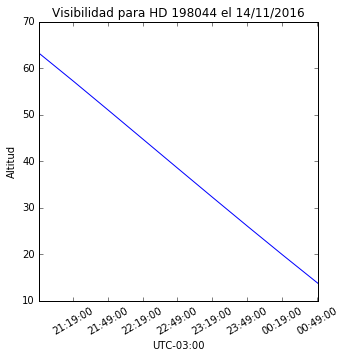

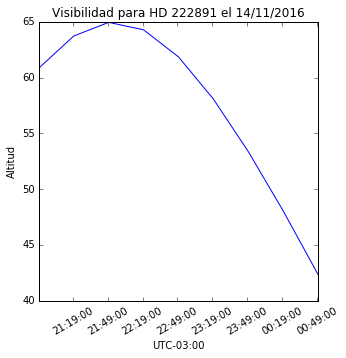

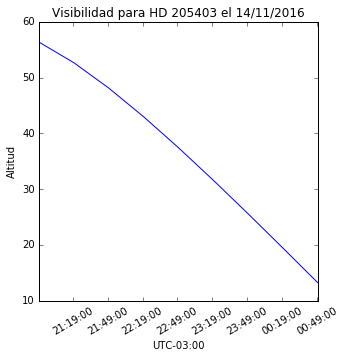

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from astropy.coordinates import Angle


visib = {key: list() for key in ebs.keys()}
for time in range(0, 9):
    oduc.date = twilight + 30 * ephem.minute * time
    # Cambio a local time
    local = ephem.localtime(oduc.date)
    
    for name in ebs.keys():        
        ebs[name].compute(oduc)
        # Obtenemos la altitud en grados.
        alti = Angle(ebs[name].alt, u.radian)
        visib[name].append((local, alti.degree))
        

for name in visib.keys():
    w = h = 5
    fig, ax = plt.subplots(figsize=(w, h))

    ax.set_xlabel('UTC-03:00')
    ax.set_ylabel('Altitud')
    date = twilight.tuple()
    date = (date[2], date[1], date[0])
    ax.set_title("Visibilidad para {} el {}/{}/{}".format(name, *date))
    ax.plot(*zip(*visib[name]))
    xfmt = mdates.DateFormatter('%H:%M:%S')
    plt.xticks(rotation=30)
    ax.xaxis.set_major_formatter(xfmt)
    plt.show()

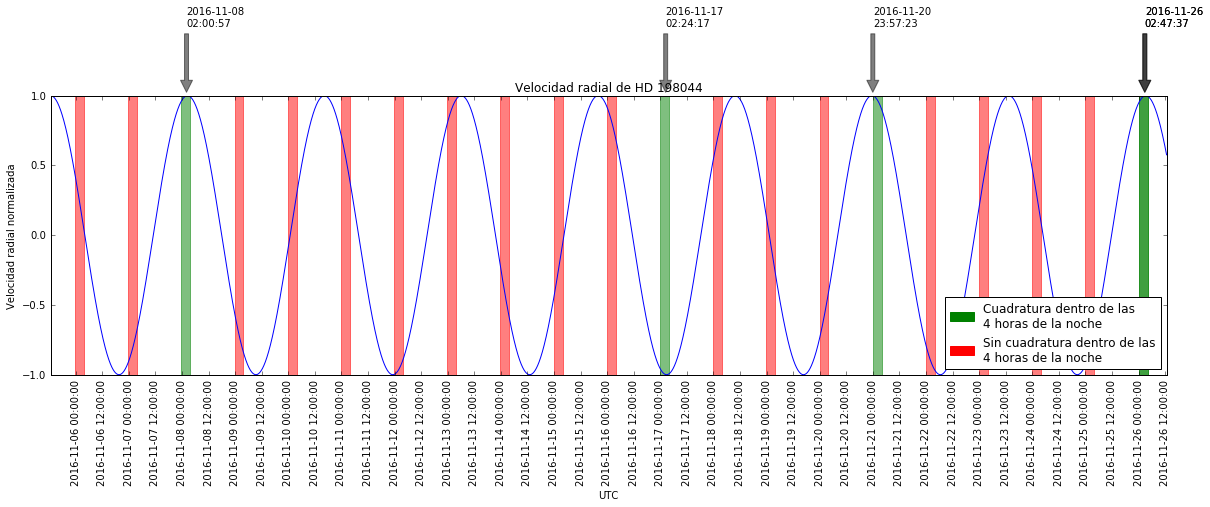

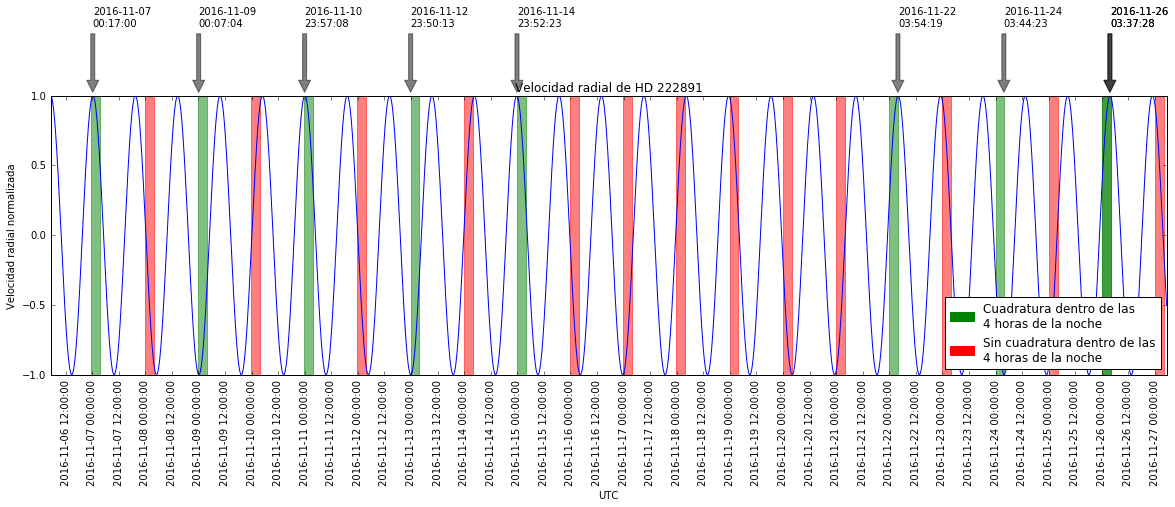

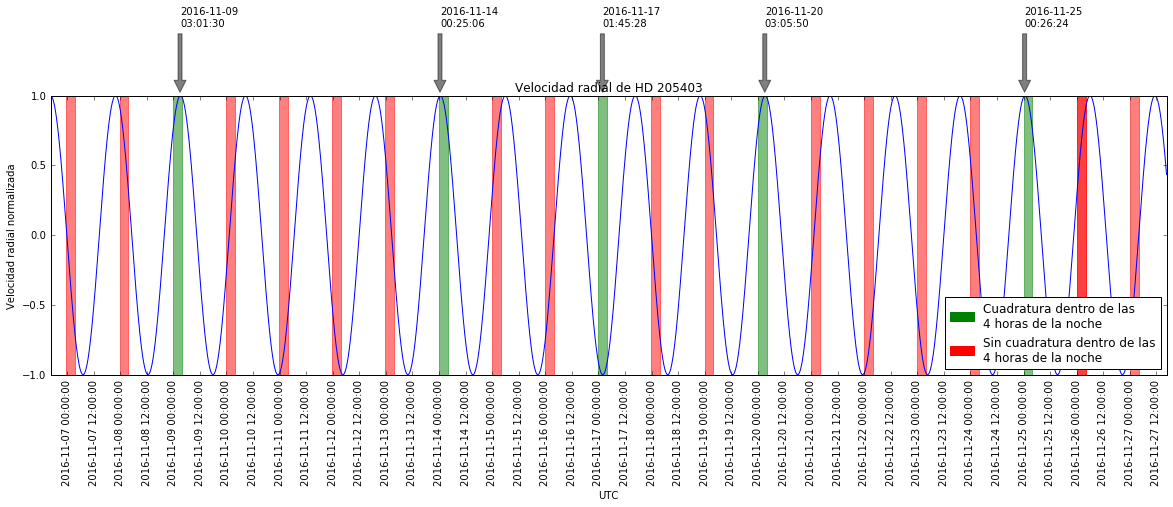

In [4]:
from astropy.time import Time, TimeDelta
import matplotlib.patches as mpatches
import numpy as np
# Name: (MJD, period [d])
ephe = {'HD 23765': (54213.264019, 1.6865),
        'HD 287039': (54224.548593, 2.2111),
        'HD 89849': (54305.226101, 3.0781),
        'BD-07 3648': (54353.170536, 2.5265),
        'HD 75767': (54285.947481, 10.2478),
        'HD 198044': (54450.509489, 5.15195),
        'HD 205403': (54123.634818, 2.4449),
        'HD 213597': (54138.602903, 2.4238),
        'HD 222891': (54150.650434, 1.59495)}
day = 86400  # Seconds

# Corregimos el MJD para obtener el de las cudraturas.
# Name: (MJD cuadratura, period [d] cuadratura)
for name in visib.keys():
    mjd = Time(ephe[name][0], format='mjd', scale='utc')
    period = ephe[name][1] / 2
    dif = TimeDelta(day * period / 2, format='sec')
    mjd += dif
    ephe[name] = (mjd.value, period)

# Calculamos desde el 7 de noviembre de 2017 en MJD:
time_start = Time('2016-11-07T00:00:00.0', format='isot', scale='utc')

def date_plus(date, plus):
    date += TimeDelta(plus * day, format='sec')
    return date.datetime
    

# (Periodo, primera cuadratura, intervalo, total de días)
def rvs(period, start_date, days, inter):
    omega = 2 * np.pi / period
    t = np.linspace(0, days, inter)
    cos_rvs = np.cos(omega * t)
    dates = date_plus(start_date, t)
    
    return np.array(list(zip(dates, cos_rvs)))

def many_twilights(time_start, days):
    twilights = []
    for lapse in range(0, (days + 1) * day, day):
        time_iter = time_start
        time_iter += TimeDelta(lapse, format='sec')

        # Twilight para ese día.
        time_in = ephem.Date("{}/{}/{}".format(time_iter.datetime.year,
                                               time_iter.datetime.month,
                                               time_iter.datetime.day))
        time_in = cal_twilight(oduc, time_in)
        # Cuatro horas más tarde
        time_out = ephem.Date(time_in + ephem.hour * 4)
        # Ahora lo transformamos a clases amables
        time_in = datetime.strptime(str(time_in), "%Y/%m/%d %H:%M:%S")
        time_out = datetime.strptime(str(time_out), "%Y/%m/%d %H:%M:%S")
        twilights.append((time_in, time_out))
    return twilights


    
for name in visib.keys():
    days = 21
    t = Time(ephe[name][0], format='mjd', scale='utc')
    # Diferencia
    dif = time_start - t
    # Cantidad de cuadraturas
    num = dif.sec // (ephe[name][1] * day)
    # Se le suma el tiempo para obtener una cuadratura por estas fechas
    t += TimeDelta(num * day * ephe[name][1], format='sec')
    
    plotear = rvs(ephe[name][1], t, days, 10000)
    twits = many_twilights(t, days)
    
    w = 5
    w = 20
    fig, ax = plt.subplots(figsize=(w, h))
    

    ax.set_xlabel('UTC')
    ax.set_ylabel('Velocidad radial normalizada')
    ax.set_title("Velocidad radial de {}".format(name))
    ax.plot(*zip(*plotear))
    if plotear[0][0] > twits[0][0]:
        del twits[0]
    for twi in twits:
        mask = plotear[:,0] > twi[0]
        mask *= plotear[:,0] < twi[1]
        mask *= np.abs(plotear[:,1]) > 0.999
        if any(mask):
            x_an = plotear[:,0][mask][0]
            ax.axvspan(twi[0], twi[1], alpha=0.5, color='green')
            ax.annotate(x_an.strftime("%Y-%m-%d\n%H:%M:%S"),
                        xy=(x_an, 1), xytext=(x_an, 1.5),
                        arrowprops=dict(facecolor='black',
                                        shrink=0.05, alpha=0.5),)

        else:
            ax.axvspan(twi[0], twi[1], alpha=0.5, color='red')
            
    green_patch = mpatches.Patch(color='green', label='Cuadratura dentro de las\n4 horas de la noche')
    red_patch = mpatches.Patch(color='red', label='Sin cuadratura dentro de las\n4 horas de la noche')
    plt.legend(handles=[green_patch, red_patch], loc=4)
    xfmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
    plt.xticks(rotation=90)
    ax.xaxis.set_major_formatter(xfmt)
    max_xticks = 50
    xloc = plt.MaxNLocator(max_xticks)
    ax.xaxis.set_major_locator(xloc)
    plt.show()


Como asumimos una excentricidad igual a 0, entonces nuestra [función de masas binarias](https://works.bepress.com/eric_addison/5/download/) corresponde a:

$f(m_2) = \frac{m_2\sin^3(i)}{(1+m_1/m_2)^2} = \frac{PV_1^3}{2\pi G}$

donde $m_2$ es la masa de la estrella secundaria, $P$ es el período, $V_1$ es la amplitud de la velocidad radial de la estrella primaria. Tenemos entonces:

$V_1 = \sqrt[3]{\frac{2\pi Gm_2\sin^3(i)}{P(1+m_1/m_2)^2}}$

Asumiendo una inclinación $i\approx 90^\circ$ y utilizando las masas según el [tipo espectral](http://www.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html)

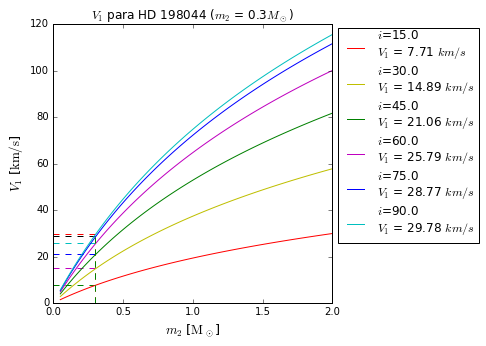

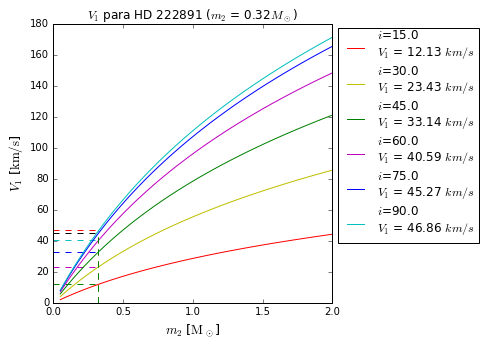

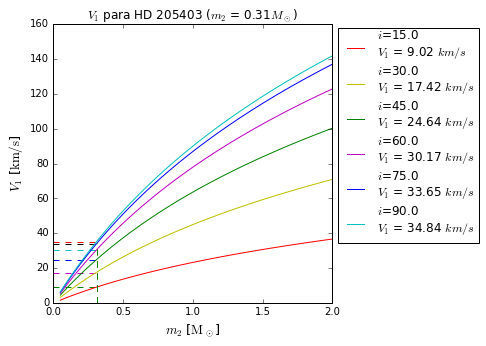

In [5]:
from astropy import constants as const
# Tomando BD-07 3648 como una K5, según sospecha Wraight et al.
host_masses = {'HD 23765': 1.1,
               'HD 287039': 1.1,
               'HD 89849': 1.1,
               'BD-07 3648': 0.58,
               'HD 75767': 1.05,
               'HD 198044': 1.12,
               'HD 205403': 1.33,
               'HD 213597': 1.59,
               'HD 222891': 1.1}
host_masses = {key: const.M_sun.value * value for (key, value) in host_masses.items()}

# Velocidades para distintas inclinaciones:
vel_inc = {key: list() for key in visib.keys() }
incs = np.arange(np.pi / 12, 7 * np.pi / 12, np.pi / 12)

comp_radius = {'HD 23765': 0.22,
               'HD 287039': 0.23,
               'HD 89849': 0.23,
               'BD-07 3648': 0.24,
               'HD 75767': 0.33,
               'HD 198044': 0.34,
               'HD 205403': 0.35,
               'HD 213597': 0.36,
               'HD 222891': 0.36}
# Si las estrellas fueran de la secuencia principal
# Además con una masa pequeña (<1.66 M_sun)
# http://faculty.buffalostate.edu/sabatojs/courses/GES639/S10/reading/mass_luminosity.pdf

def main_seq(radius):
    return np.power(radius / 1.06, 1 / 0.945)

comp_masses = {key: main_seq(value) for (key, value) in comp_radius.items()}

def vr_binary(mass1, mass2, period, inc):
    num = 2 * np.pi * const.G.value * mass2 * np.power(np.sin(inc), 3)
    den = period * day * np.power(1 + mass1 / mass2, 2)
    return np.power(num / den, 1/3)

for name in visib.keys():   
    period = 2 * ephe[name][1]
    masses = np.linspace(0.05, 2, 100)
    comp_mass = comp_masses[name]
    
    w = h = 5
    fig, ax = plt.subplots(figsize=(w, h))

    ax.set_xlabel('$m_2$ [$\mathrm{M}_\odot$]', fontsize=13)
    ax.set_ylabel('$V_1$ [$\mathrm{km/s}$]', fontsize=13)
    ax.set_title("$V_1$ para {} ($m_2$ = {}$ M_\odot$)".format(name, np.round(comp_mass, 2)))
    
    for inc in incs:
        masses = masses * const.M_sun.value
        vrs = vr_binary(host_masses[name], masses, period, inc) / 1000
        masses = masses / const.M_sun.value
        idx = (np.abs(masses-comp_mass)).argmin()
        vrss = vrs[idx]
        
        vrss = np.round(vrss, 2)
        vel_inc[name].append(vrss)

    
        ax.plot([comp_mass, comp_mass],[0, vrss], linewidth=1., linestyle="--")
        ax.plot([0, comp_mass],[vrss, vrss], linewidth=1., linestyle="--")
        
        inc = np.round(np.degrees(inc), 0)
        text = '$i$={}\n$V_1$ = {} $km/s$'.format(inc, vrss)

        ax.plot(masses, vrs, label=text)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.6))
    plt.show()

La resolución de PUCHEROS corresponde a $R \sim 18000$ y necesitamos una [resolución](http://ster.kuleuven.be/~stevenb/downloads/summerschool_talks/Marsh_1.pdf) de $c/V_1$

In [6]:
from astropy.table import Table
from astropy.io import ascii
table_boo = Table(names=('EB', *np.degrees(incs)),
                  meta={'name': 'first table'},
                  dtype=('O', *('bool' for _ in range(0, len(incs)))))
table_vec = Table(names=('EB', *np.degrees(incs)),
                  meta={'name': 'first table'},
                  dtype=('O', *('float' for _ in range(0, len(incs)))))
table_res = Table(names=('EB', *np.degrees(incs)),
                  meta={'name': 'first table'},
                  dtype=('O', *('float' for _ in range(0, len(incs)))))

c_kms = const.c.to('km/s')
for name in visib.keys():
    add_boo = [name]
    add_vec = [name]
    add_res = [name]
    for v in vel_inc[name]:
        res = c_kms.value / v < 18000
        add_boo.append(res)
        add_vec.append(v)
        add_res.append(np.round(c_kms.value / v)) 
    table_res.add_row(add_res)
    table_vec.add_row(add_vec)
    table_boo.add_row(add_boo)
table_res.show_in_notebook()

idx,EB,15.0,30.0,45.0,60.0,75.0,90.0
0,HD 198044,38884.0,20134.0,14235.0,11624.0,10420.0,10067.0
1,HD 222891,24715.0,12795.0,9046.0,7386.0,6622.0,6398.0
2,HD 205403,33236.0,17210.0,12167.0,9937.0,8909.0,8605.0


In [7]:
table_boo.show_in_notebook()

idx,EB,15.0,30.0,45.0,60.0,75.0,90.0
0,HD 198044,False,False,True,True,True,True
1,HD 222891,False,True,True,True,True,True
2,HD 205403,False,True,True,True,True,True


In [8]:
table_vec.show_in_notebook()

idx,EB,15.0,30.0,45.0,60.0,75.0,90.0
0,HD 198044,7.71,14.89,21.06,25.79,28.77,29.78
1,HD 222891,12.13,23.43,33.14,40.59,45.27,46.86
2,HD 205403,9.02,17.42,24.64,30.17,33.65,34.84


[Podemos](http://www.stsci.edu/instruments/wfpc2/Wfpc2_hand/HTML/W2_59.html) escribir las señal como:

$S = C \cdot t \cdot 10^{-0.4V}$

donde $C$ es una constante. A su vez podemos escribir el ruido como $N = \sqrt(S)$. Entonces la señal al ruido corresponde a:

$\frac{S}{N} = C^{1/2} \cdot t^{1/2}\cdot 10^{-0.2V}$


Considerando que la precisión de la velocidad ($Pv$) es [inversamente proporcional](https://www.astro.umd.edu/~olling/FAME/otm_spec_rpo_2004_01.pdf) a la señal al ruido, entonces:

$Pv = (A \cdot t^{1/2}\cdot 10^{-0.2V})^{-1}$

Pero sabemos que para $V=3.5$, $t=300$ tenemos:

$10 = (A \cdot 300^{1/2}\cdot 10^{-0.2\cdot3.5})^{-1}$

$\Rightarrow A = 0.0289361$

como queremos conocer el tiempo para una $Pv$ de 100 metros por segundo, entonces:

$t = \left(2.89361\cdot 10^{-0.2\cdot V}\right)^{-2}$



In [9]:
mags = {'HD 23765': 9.53,
        'HD 287039': 9.88,
        'HD 89849': 9.15,
        'BD-07 3648': 11.3,
        'HD 75767': 6.59,
        'HD 198044': 7.2,
        'HD 205403': 8.02,
        'HD 213597': 7.81,
        'HD 222891': 8.07}

def time_stn(mag, pv):
    inside = pv * 0.0289361 * np.power(10, -0.2 * mag)
    return np.power(inside, -2) / 60

print(45 * "#" + "\n" + 45 * "#")
print("Nombre\t\t#\tTiempo en minutos\n\t\t#")
for name in visib.keys():
    print("{}\t#\t{}".format(name, time_stn(mags[name], 100)))
print("\n" + 45 * "#" + "\n" + 45 * "#")

#############################################
#############################################
Nombre		#	Tiempo en minutos
		#
HD 198044	#	1.5099715211687452
HD 222891	#	3.36487361216958
HD 205403	#	3.213429352521117

#############################################
#############################################


Podemos notar que BD-07 3648 es la binaria que tardará más tiempo, además de que su altitud disminuirá conforme avance la noche. Para los otros dos tenemos tiempos similares, sin embargo HD 205403 alcanzará su máxima altitud máxima antes que HD 222891. Pero además HD 222891 tendrá su mayor velocidad radial en las primeras horas de la noche y HD 205403 a las últimas. Por lo que el mejor orden sería:

1. HD 222891
2. BD-07 3648
3. HD 205403	